In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import multivariate_normal
from scipy.stats import gaussian_kde
from scipy.special import expit
from scipy.special import logsumexp
from scipy.optimize import minimize
from scipy.optimize import LinearConstraint
from scipy.signal import convolve
from scipy.interpolate import interp1d

import divebomb

import time
import pickle

import importlib

import Preprocessor
import Parameters
import HHMM
import Visualisor

random.seed(0)
np.random.seed(0)

# Initialize parameters

In [2]:
ndives = 10

# dive duration parameters
dd_mu = np.array([60.0,120.0])
dd_sig = np.array([5.0,10.0])

dd_shape = np.square(dd_mu)/np.square(dd_sig)
dd_scale = np.square(dd_sig)/np.array(dd_mu)

# FoVeDBA parameters (this is for the SQUARE of the FoVeDBA)
FoVeDBA_sin_shape = np.array([[(2.0/n)**2 for n in range(1,52)],[(2.0/n)**2 for n in range(1,52)]])
FoVeDBA_sin_scale = np.ones((2,51))
FoVeDBA_sin_shape[1,2] = 20

# average acceleration parameters
acc_mu = np.array([1.0,1.0])
acc_sig = np.array([0.05,0.05])

# number of states for each substate
K0 = 2
K1 = 2

# randomly initialize a probablity transition matrix
ptm_crude = np.array([[0.4,0.6],
                      [0.6,0.4]])

ptm_fine = [np.array([[0.25,0.75],
                      [0.75,0.25]]),
            np.array([[0.75,0.25],
                      [0.25,0.75]])]
    
# randomly intialize a correlation within states
corr_crude = [0.0,0.0]
corr_fine = [0.95,0.95]

# train new models?
train_new = True

In [3]:
# initialize the initial states
delta_crude = np.ones(K0)/K0
for _ in range(100):
    delta_crude = delta_crude.dot(ptm_crude)
    
delta_fines = []
for k0 in range(K0):
    delta_fine = np.ones(K1)/K1
    for _ in range(100):
        delta_fine = delta_fine.dot(ptm_fine[k0])
    delta_fines.append(delta_fine)

# Create Data 

In [4]:
data = []
data_V = []
data_FV = []
freqs = np.fft.rfftfreq(100, d=1/50.0)
thresh = 5
thresh_ind = max(np.where(freqs <= thresh)[0]) + 1
time = 0

acc_mean = 1.0
acc_std = 1.0

for dive_num in range(ndives):
    
    # select dive type
    if dive_num == 0:
        dive_type = np.random.choice(K0,p=delta_crude)
        dd_mu_t = np.copy(dd_mu[dive_type])
    else:
        dive_type_tm1 = dive_type
        dive_type = np.random.choice(K0,p=ptm_crude[dive_type,:])
        dd_mu_t = np.copy(dd_mu[dive_type])
        dd_mu_t = corr_crude[dive_type]*dd_tm1 + (1.0-corr_crude[dive_type])*dd_mu_t
    
    # select dive duration
    dd_sig_t = dd_sig[dive_type]
    dd_shape_t = np.square(dd_mu_t)/np.square(dd_sig_t)
    dd_scale_t = np.square(dd_sig_t)/np.array(dd_mu_t)
    
    dive_duration = gamma.rvs(dd_shape_t,0,dd_scale_t)
    dd_tm1 = dive_duration
    datum = {'dive_type': dive_type, 'dive_duration': dive_duration}
    datum_V = {'dive_type': dive_type, 'dive_duration': dive_duration}
    datum_FV = {'dive_type': dive_type, 'dive_duration': dive_duration}
    nsegs = int(dive_duration/2.0)
    
    subdive_features = []
    subdive_features_V = []
    subdive_features_FV = []
    
    for seg_num in range(nsegs):
        seg = {}
        seg_V = {}
        seg_FV = {}
        
        # find seg type
        if seg_num == 0:
            subdive_type = np.random.choice(K1,p=delta_fines[dive_type])
            FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
            acc_mu_t = np.copy(acc_mu[subdive_type])
        else:
            subdive_type = np.random.choice(K1,p=ptm_fine[dive_type][subdive_type,:])
            FoVeDBA_sin_mu_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]
            acc_mu_t = np.copy(acc_mu[subdive_type])
            acc_mu_t = corr_fine[subdive_type]*acc_tm1 + (1.0-corr_fine[subdive_type])*acc_mu_t
        
        seg['subdive_type'] = subdive_type
        seg_FV['subdive_type'] = subdive_type
        seg_V['subdive_type'] = subdive_type

        # find average acceleration
        acc_sig_t = acc_sig[subdive_type]
        
        # find FoVeDBA
        FoVeDBA_sin_sig2_t = FoVeDBA_sin_shape[subdive_type,:]*FoVeDBA_sin_scale[subdive_type,:]**2
        FoVeDBA_sin_shape_t = np.square(FoVeDBA_sin_mu_t)/FoVeDBA_sin_sig2_t
        FoVeDBA_sin_scale_t = FoVeDBA_sin_sig2_t/FoVeDBA_sin_mu_t
        FoVeDBA_sin = gamma.rvs(FoVeDBA_sin_shape_t,0,FoVeDBA_sin_scale_t)
        FoVeDBA_sin_tm1 = np.copy(FoVeDBA_sin)

        seg['FoVeDBA_full'] = FoVeDBA_sin.T
        seg['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001
        seg_FV['FoVeDBA'] = np.sum(FoVeDBA_sin.T[1:thresh_ind]) + 0.001
        
        # find VeDBA
        pm = (2*np.random.choice(2,size = FoVeDBA_sin.shape)-1)
        FoVeDBA = pm*np.sqrt(FoVeDBA_sin)*1.0j
        A = np.array(np.fft.irfft(FoVeDBA))
        V0 = norm.rvs(acc_mu_t,acc_sig_t)
        acc_tm1 = V0
        A += np.linspace(V0,V0,100).T
        
        seg['A'] = A
        seg_V['A'] = np.mean(A)
        seg_FV['A'] = np.mean(A)
        
        # find time
        seg['time'] = np.arange(time,time+2,1/50)
        time += 2
        
        subdive_features.append(seg)
        subdive_features_V.append(seg_V)
        subdive_features_FV.append(seg_FV)
        
    datum['subdive_features'] = subdive_features
    datum_V['subdive_features'] = subdive_features_V
    datum_FV['subdive_features'] = subdive_features_FV
    
    data.append(datum)
    data_V.append(datum_V)
    data_FV.append(datum_FV)

# Visualize Data 

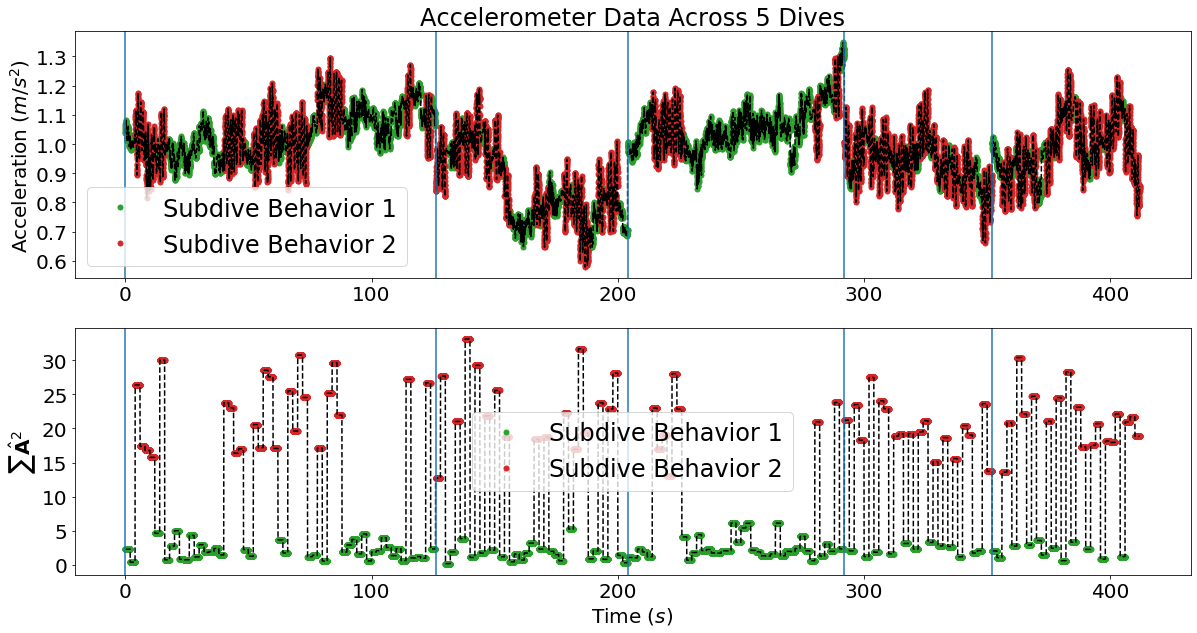

In [5]:
dive_colors = [cm.get_cmap('tab10')(i) for i in range(K0)]
dive_legend = ['Dive Type %d' % (i+1) for i in range(K0)]

subdive_colors = [cm.get_cmap('tab10')(i+K0) for i in range(K1)]
subdive_legend = ['Subdive Behavior %d' % (i+1) for i in range(K1)]

def plot_col(col,data,color,level,nplots,subplot):

    dive_starts = []
    
    if color == 'dive':
        x = [list([]) for _ in range(K0+1)]
        y = [list([]) for _ in range(K0+1)]
    else:
        x = [list([]) for _ in range(K1+1)]
        y = [list([]) for _ in range(K1+1)]
    
    plt.subplot(nplots,1,subplot)
    for datum in data[:5]:
        dive_type = datum['dive_type']
        dive_starts.append(datum['subdive_features'][0]['time'][0])

        for seg in datum['subdive_features']:
            subdive_type = seg['subdive_type']
            
            if col not in seg:
                continue
            
            if level == 0:
                seg_data = [seg[col]]*len(seg['time'])
            else:
                seg_data = seg[col]
            
            x[-1].extend(seg['time'])
            y[-1].extend(seg_data)
            if color == 'dive':
                x[dive_type].extend(seg['time'])
                y[dive_type].extend(seg_data)
            else:
                x[subdive_type].extend(seg['time'])
                y[subdive_type].extend(seg_data)

    if color == 'dive':
        c = dive_colors
        l = dive_legend
    else:
        c = subdive_colors
        l = subdive_legend

    for state in range(K0):
        plt.plot(x[state],y[state],'.',color=c[state],markersize=10)
    
    plt.legend(l,prop={'size': 24})
    plt.plot(x[-1],y[-1],'k--')
    
    for dive_start in dive_starts:
        plt.axvline(x=dive_start)
    
    return

plt.subplots(2,1,figsize=(20,10))
plot_col('A',data,'subdive',1,2,1)
plt.title('Accelerometer Data Across 5 Dives', fontsize = 24)
plt.ylabel('Acceleration $(m/s^2)$', fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plot_col('FoVeDBA',data,'subdive',0,2,2)
plt.ylabel('$\sum \hat{\mathbf{A}}^2$',fontsize = 20)
plt.xlabel('Time ($s$)',fontsize = 20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

#plot_col('Ax',data,'subdive',1,4,3)
#plot_col('FoVeDBA',data,'subdive',0,4,4)
#plt.show()
plt.savefig("../Plots/sim_data.png")

# Try to relearn generative parameters

In [6]:
# no hierarchical structure
pars = Parameters.Parameters()
pars.K = [1,2]
pars.features = [{'dive_duration':{'corr':True,'f':'gamma'}},
                 {'FoVeDBA':{'corr':False,'f':'gamma'},
                  'A':{'corr':True,'f':'normal'}}]

hmm_FV = HHMM.HHMM(pars,data_FV)

if train_new:
    hmm_FV.train_DM(data_FV)
    hmm_FV.save('hhm_FV')
else:
    hmm_FV = hmm_FV.load('hhm_FV')
    
print(hmm_FV.theta)
print(hmm_FV.eta)

for dive_num,datum in enumerate(data_FV):
    _,_,posts,_ = hmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    for i,post in enumerate(posts.T):
        data[dive_num]['subdive_features'][i]['hmm_FV_dive'] = 0.0
        data[dive_num]['subdive_features'][i]['hmm_FV_subdive'] = post[1]

20
428.6665470600128
[{'dive_duration': {'mu': array([87.46106787]), 'sig': array([23.35783432]), 'corr': array([-4.29439586])}}, [{'FoVeDBA': {'mu': array([ 2.24256977, 21.69351993]), 'sig': array([1.38761387, 4.57261839]), 'corr': array([-0.86187602, -2.17220019])}, 'A': {'mu': array([0.97622936, 0.94157268]), 'sig': array([0.04708165, 0.04679112]), 'corr': array([2.68053059, 2.38641532])}}]]
[array([[0.]]), [array([[ 0.        , -0.45303399],
       [-0.1796138 ,  0.        ]])]]


In [7]:
# only use VeDBA
pars = Parameters.Parameters()
pars.K = [2,2]
pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'A':{'corr':True,'f':'normal'}}]

hhmm_V = HHMM.HHMM(pars,data_V)

if train_new:
    hhmm_V.train_DM(data_V)
    hhmm_V.save('hhmm_V')
else:
    hhmm_V = hhmm_V.load('hhmm_V')

print(hhmm_V.theta)
print(hhmm_V.eta)

# crude posterior
_,_,posts_crude,_ = hhmm_V.fwd_bwd(data_V,[0])

# fine posterior
for dive_num,datum in enumerate(data_V):
    data[dive_num]['hhmm_v'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_V.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_V_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_V_dive'] = posts_crude.T[dive_num,1]

24
624.1674530506134
[{'dive_duration': {'mu': array([ 77.81062338, 127.67667452]), 'sig': array([17.79156124,  0.39424284]), 'corr': array([ 0.92478483, -2.50106314])}}, [{'A': {'mu': array([0.79127245, 1.05797416]), 'sig': array([0.04578835, 0.04540714]), 'corr': array([2.18314625, 2.4307195 ])}}, {'A': {'mu': array([0.79127245, 1.05797416]), 'sig': array([0.04578835, 0.04540714]), 'corr': array([2.18314625, 2.4307195 ])}}]]
[array([[ 0.        , -2.10811505],
       [-1.8304273 ,  0.        ]]), [array([[ 0.        , -0.66803675],
       [-1.25317436,  0.        ]]), array([[ 0.        , -0.17364587],
       [-2.5015811 ,  0.        ]])]]


In [8]:
# don't include autocorrelation
pars = Parameters.Parameters()
pars.K = [2,2]
pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA':{'corr':False,'f':'gamma'},
                  'A':{'corr':False,'f':'normal'}}]

hhmm_FV_uncorr = HHMM.HHMM(pars,data_FV)

if train_new:
    hhmm_FV_uncorr.train_DM(data_FV)
    hhmm_FV_uncorr.save('hhmm_FV_uncorr')
else:
    hhmm_FV_uncorr = hhmm_FV_uncorr.load('hhmm_FV_uncorr')
    
print(hhmm_FV_uncorr.theta)
print(hhmm_FV_uncorr.eta)


# crude posterior
_,_,posts_crude,_ = hhmm_FV_uncorr.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    data[dive_num]['hhmm_FV_uncorr'] = posts_crude.T[dive_num,1]
    _,_,posts_fine_0,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV_uncorr.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_uncorr_dive'] = posts_crude.T[dive_num,1]

30
1276.3954050540924
[{'dive_duration': {'mu': array([ 67.19215209, 108.02652959]), 'sig': array([ 8.21366474, 17.87319541]), 'corr': array([-2.95963165, -3.59402944])}}, [{'FoVeDBA': {'mu': array([ 2.24704761, 21.67401537]), 'sig': array([1.39293172, 4.56810913]), 'corr': array([-0.05630294,  0.41643458])}, 'A': {'mu': array([0.98757448, 0.96317389]), 'sig': array([0.11176461, 0.10938138]), 'corr': array([-0.34227202, -1.37928114])}}, {'FoVeDBA': {'mu': array([ 2.24704761, 21.67401537]), 'sig': array([1.39293172, 4.56810913]), 'corr': array([-0.05630294,  0.41643458])}, 'A': {'mu': array([0.98757448, 0.96317389]), 'sig': array([0.11176461, 0.10938138]), 'corr': array([-0.34227202, -1.37928114])}}]]
[array([[ 0.        , -0.42234346],
       [-0.86003894,  0.        ]]), [array([[0.        , 1.21159617],
       [0.74700814, 0.        ]]), array([[ 0.        , -1.31916787],
       [-0.93784259,  0.        ]])]]


In [9]:
# the whole shebang
pars = Parameters.Parameters()
pars.K = [2,2]
pars.features = [{'dive_duration':{'corr':False,'f':'gamma'}},
                 {'FoVeDBA':{'corr':False,'f':'gamma'},
                  'A':{'corr':True,'f':'normal'}}]

hhmm_FV = HHMM.HHMM(pars,data_FV)

if train_new:
    hhmm_FV.train_DM(data_FV)
    hhmm_FV.save('hhmm_FV')
else:
    hhmm_FV = hhmm_FV.load('hhmm_FV')
    
print(hhmm_FV.theta)
print(hhmm_FV.eta)

# crude posterior
_,_,posts_crude,_ = hhmm_FV.fwd_bwd(data_FV,[0])

# fine posterior
for dive_num,datum in enumerate(data_FV):
    _,_,posts_fine_0,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,0])
    _,_,posts_fine_1,_ = hhmm_FV.fwd_bwd(datum['subdive_features'],[1,1])
    for i,(post_fine_0,post_fine_1) in enumerate(zip(posts_fine_0.T,posts_fine_1.T)):
        p = posts_crude.T[dive_num,0]*post_fine_0[1] + \
            posts_crude.T[dive_num,1]*post_fine_1[1]
        data[dive_num]['subdive_features'][i]['hhmm_FV_subdive'] = p
        data[dive_num]['subdive_features'][i]['hhmm_FV_dive'] = posts_crude.T[dive_num,1]

30
1280.9506120681763
[{'dive_duration': {'mu': array([ 81.67138406, 146.14661968]), 'sig': array([34.83228345, 78.40521974]), 'corr': array([-3.15189797, -4.67284368])}}, [{'FoVeDBA': {'mu': array([ 2.24969678, 21.67993955]), 'sig': array([1.39361097, 4.57290735]), 'corr': array([-0.705924  , -1.20079547])}, 'A': {'mu': array([0.97885578, 0.9410281 ]), 'sig': array([0.04731757, 0.04681102]), 'corr': array([2.57292941, 2.32166868])}}, {'FoVeDBA': {'mu': array([ 2.24969678, 21.67993955]), 'sig': array([1.39361097, 4.57290735]), 'corr': array([-0.705924  , -1.20079547])}, 'A': {'mu': array([0.97885578, 0.9410281 ]), 'sig': array([0.04731757, 0.04681102]), 'corr': array([2.57292941, 2.32166868])}}]]
[array([[0.        , 0.26851466],
       [0.7022324 , 0.        ]]), [array([[0.        , 1.12398624],
       [0.74426656, 0.        ]]), array([[ 0.        , -1.39531   ],
       [-0.95458359,  0.        ]])]]


In [15]:
data[0]

{'dive_type': 1,
 'dive_duration': 127.28336781598063,
 'subdive_features': [{'subdive_type': 0,
   'FoVeDBA_full': array([7.51655107e+000, 5.75519199e-001, 1.46058065e+000, 2.16170559e-002,
          1.86663206e-002, 2.89386329e-010, 1.06040749e-001, 1.07746971e-001,
          1.06737591e-002, 2.04046215e-003, 1.36559809e-006, 1.28844691e-001,
          7.04010120e-017, 3.58699840e-006, 1.58763414e-014, 4.04449102e-014,
          6.99433303e-016, 3.36716250e-014, 3.60010824e-033, 9.50650688e-123,
          7.41839765e-020, 2.24555072e-108, 8.12835167e-059, 2.87142936e-052,
          1.32917439e-155, 1.24319384e-134, 2.04121754e-109, 1.19329671e-120,
          5.80343258e-202, 4.00179144e-194, 7.94957973e-105, 5.36517174e-260,
          1.10785629e-277, 7.50884936e-096, 1.34467813e-067, 0.00000000e+000,
          1.23894393e-315, 0.00000000e+000, 2.94613265e-146, 1.44849477e-064,
          7.71141222e-243, 0.00000000e+000, 1.90221904e-015, 1.01435758e-085,
          4.46857360e-074, 0.

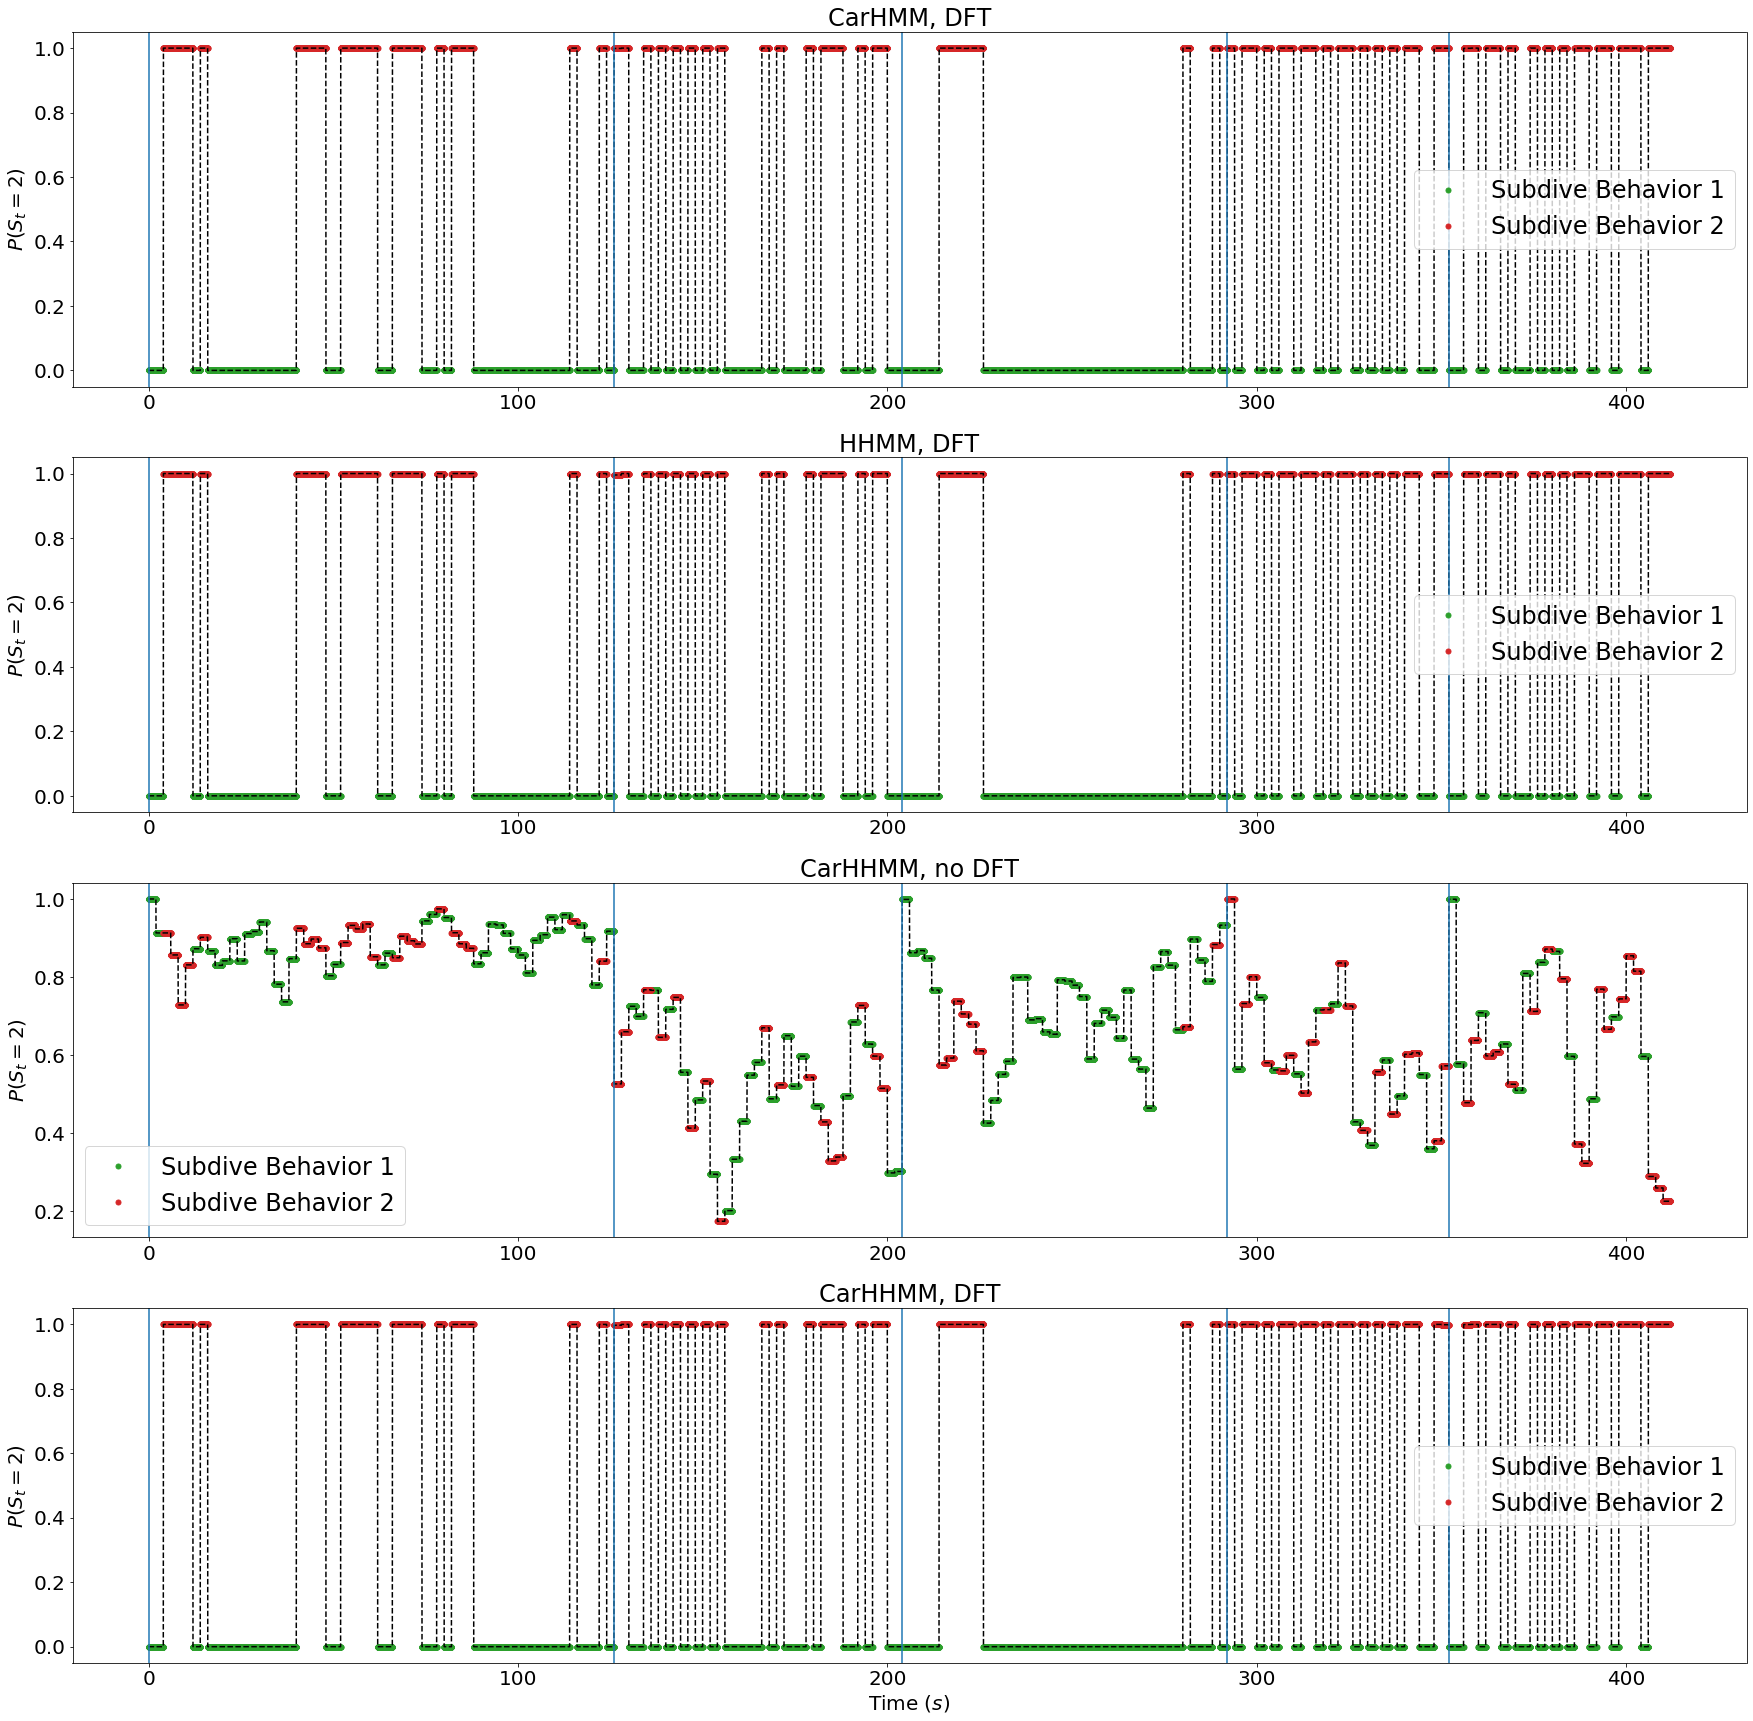

In [17]:
plt.subplots(3,1,figsize=(30,30))

plot_col('hmm_FV_subdive',data,'subdive',0,4,1)
plt.title("CarHMM, DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)

plot_col('hhmm_FV_uncorr_subdive',data,'subdive',0,4,2)
plt.title("HHMM, DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)

plot_col('hhmm_V_subdive',data,'subdive',0,4,3)
plt.title("CarHHMM, no DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)


plot_col('hhmm_FV_subdive',data,'subdive',0,4,4)
plt.title("CarHHMM, DFT",fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel('$P(S_t = 2)$',fontsize=20)
plt.xlabel('Time ($s$)',fontsize=20)

plt.savefig('test2')

In [11]:
hmm_FV.theta

[{'dive_duration': {'mu': array([87.46106787]),
   'sig': array([23.35783432]),
   'corr': array([-4.29439586])}},
 [{'FoVeDBA': {'mu': array([ 2.24256977, 21.69351993]),
    'sig': array([1.38761387, 4.57261839]),
    'corr': array([-0.86187602, -2.17220019])},
   'A': {'mu': array([0.97622936, 0.94157268]),
    'sig': array([0.04708165, 0.04679112]),
    'corr': array([2.68053059, 2.38641532])}}]]

In [12]:
hhmm_V.theta

[{'dive_duration': {'mu': array([ 77.81062338, 127.67667452]),
   'sig': array([17.79156124,  0.39424284]),
   'corr': array([ 0.92478483, -2.50106314])}},
 [{'A': {'mu': array([0.79127245, 1.05797416]),
    'sig': array([0.04578835, 0.04540714]),
    'corr': array([2.18314625, 2.4307195 ])}},
  {'A': {'mu': array([0.79127245, 1.05797416]),
    'sig': array([0.04578835, 0.04540714]),
    'corr': array([2.18314625, 2.4307195 ])}}]]

In [13]:
hhmm_FV_uncorr.theta

[{'dive_duration': {'mu': array([ 67.19215209, 108.02652959]),
   'sig': array([ 8.21366474, 17.87319541]),
   'corr': array([-2.95963165, -3.59402944])}},
 [{'FoVeDBA': {'mu': array([ 2.24704761, 21.67401537]),
    'sig': array([1.39293172, 4.56810913]),
    'corr': array([-0.05630294,  0.41643458])},
   'A': {'mu': array([0.98757448, 0.96317389]),
    'sig': array([0.11176461, 0.10938138]),
    'corr': array([-0.34227202, -1.37928114])}},
  {'FoVeDBA': {'mu': array([ 2.24704761, 21.67401537]),
    'sig': array([1.39293172, 4.56810913]),
    'corr': array([-0.05630294,  0.41643458])},
   'A': {'mu': array([0.98757448, 0.96317389]),
    'sig': array([0.11176461, 0.10938138]),
    'corr': array([-0.34227202, -1.37928114])}}]]

In [14]:
hhmm_FV.theta

[{'dive_duration': {'mu': array([ 81.67138406, 146.14661968]),
   'sig': array([34.83228345, 78.40521974]),
   'corr': array([-3.15189797, -4.67284368])}},
 [{'FoVeDBA': {'mu': array([ 2.24969678, 21.67993955]),
    'sig': array([1.39361097, 4.57290735]),
    'corr': array([-0.705924  , -1.20079547])},
   'A': {'mu': array([0.97885578, 0.9410281 ]),
    'sig': array([0.04731757, 0.04681102]),
    'corr': array([2.57292941, 2.32166868])}},
  {'FoVeDBA': {'mu': array([ 2.24969678, 21.67993955]),
    'sig': array([1.39361097, 4.57290735]),
    'corr': array([-0.705924  , -1.20079547])},
   'A': {'mu': array([0.97885578, 0.9410281 ]),
    'sig': array([0.04731757, 0.04681102]),
    'corr': array([2.57292941, 2.32166868])}}]]